# MagAO-X + POPPY: Pupil Plane Check
The goal of this file is to understand why the beam diameter of the Woofer DM does not match up with the expected value while we are using Zemax-inputted distances.

In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm 
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
We are building to the woofer DM.

#### Changed values:
- fl_OAP0 changed to 143.55mm versus calculated value
- d_peri2_oap0 changed to 110.346mm from 10mm in Zemax file.

In [2]:
# note: u.m is in meters
testWavelength = 656e-9 * u.m # H-alpha
npix = 256  # resolution

# physical radius values
# M1_radius = 6.5/2 * u.m # This is the correct value to use.
#M2_radius = 1.339/2 * u.m # This is the correct value to use.
M1_radius = 3.2392 * u.m # This is the Zemax inputted value.
M2_radius = 0.632839 * u.m # this is the Zemax inputted value
M3_radius = 0.439879 * u.m # Using largest value from various Zemax files
oap_radius = 0.0254 * u.m # 2 inch diameter OAP
flat_radius = 0.025 * u.m # 50mm diameter

# focal lengths
fl_M1 = 8.128 * u.m
fl_ratio_M2 = 1.07
#fl_M2 = M2_diam * fl_ratio_M2
fl_M2 = 1.43273 * u.m # This is the correct value to use.
fl_OAP0 = 0.14355 * u.m # This is the correct value to use, not the Zemax calculated one.

# Math check for the OAPs in the zemax file
oap_roc = np.array([204.431, 337.544, 589.294, 2106.685, 1008.520, 1220.84, 1220.84, 1220.84]) / 1000 
oap_angle = np.array([65, 53, 20, 15, 15, 15, 15, 15])
oap_fl = oap_roc/(1+np.cos(np.deg2rad(oap_angle))) # equation defined in a presentation somewhere

# Primary and Secondary mirrors
M1 = poppy.QuadraticLens(fl_M1, name='M-1')
M2 = poppy.QuadraticLens(fl_M2, name='M-2')

# OAP mirrors
#OAP0 = poppy.QuadraticLens(oap_fl[0] * u.m, name='OAP-0')
OAP0 = poppy.QuadraticLens(fl_OAP0, name='OAP-0')

In Zemax, the distances between optics are measured from vertex to vertex. All the distances used will be from Zemax.

The only exception is that d_peri2_oap0 is not following the Zemax file but rather calculated from fl_OAP0 - d_f11fp_per2. 

In [3]:
# propagation distances based on Zemax
d_m1_m2 = 9.72205 * u.m
d_m2_m3 = 9.02279 * u.m
d_m3_wfsdichroic = 4.849516 * u.m
d_wfsdichroic_peri1 = 0.100 * u.m
d_peri1_f11fp = 0.030 * u.m
d_f11fp_peri2 = 0.033204 * u.m
#d_peri2_oap0 = 0.010 * u.m # Zemax value. Doesn't look right one bit.
d_peri2_oap0 = 0.110346 * u.m # Calculated by FL_OAP0 - d_f11fp_peri2
d_oap0_k1 = 0.081125 * u.m
d_k1_k2 = 0.025 * u.m
d_k2_k3 = 0.025 * u.m
d_k3_woofer = 0.055 * u.m

I also pre-calculated the F/11 correction distance from before and to make things faster, I'm just shoving it back in.

In [4]:
# Saved F/# correction values, calculated from no-aberrations version
f11_delta = 0.15491726 * u.m

Adding the surface files for the optics

In [5]:
def surfFITS(file_loc, optic_type, opdunit, name):
    optic_fits = fits.open(file_loc)
    optic_fits[0].data = np.float_(optic_fits[0].data) # typecasting
    if optic_type == 'opd':
        optic_surf = poppy.FITSOpticalElement(name = name, opd=optic_fits, opdunits = opdunit)
    else:
        optic_surf = poppy.FITSOpticalElement(name = name, transmission=optic_fits)
    return optic_surf

In [6]:
# Primary Mirror Surface
M1_surf = surfFITS(file_loc='data/ClayM1_0mask_meters_new.fits', optic_type='opd', opdunit='meters', 
                   name='M-1 surface')
# Secondary Mirror Surface
M2_surf = surfFITS(file_loc='data/M2_fitpsd.fits', optic_type='opd', opdunit='nanometers', 
                   name='M-2 surface')
# Tertiary Mirror Surface
M3_surf = surfFITS(file_loc='data/M3_fitpsd.fits', optic_type='opd', opdunit='nanometers', 
                   name='M-3 surface')

# OAPs
OAP0_surf = surfFITS(file_loc='data/oap_HP_0.fits', optic_type='opd', opdunit='nanometers', name='OAP-0 surface')

# Flats
peri1_surf = surfFITS(file_loc='data/flat_l100_0.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-1 surface')
peri2_surf = surfFITS(file_loc='data/flat_l100_1.fits', optic_type='opd', opdunit='nanometers', 
                          name='F-2 surface')
K1_surf = surfFITS(file_loc='data/flat_l100_2.fits', optic_type='opd', opdunit='nanometers', 
                          name='K-1 surface')
K2_surf = surfFITS(file_loc='data/flat_l100_3.fits', optic_type='opd', opdunit='nanometers', 
                          name='K-2 surface')
K3_surf = surfFITS(file_loc='data/flat_l100_4.fits', optic_type='opd', opdunit='nanometers', 
                          name='K-3 surface')

In [7]:
pupil = surfFITS(file_loc='data/MagAOX_f11_pupil_256_unmasked.fits', optic_type='trans', opdunit='none', 
                 name='MagAO-X Pupil (unmasked)')

## Build Magellan Telescope
We're building to the Woofer DM because we are finding an issue with the size of the beam at this plane.

In [8]:
magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, 
                                       npix=npix*2,
                                       beam_ratio=.34)
# Entrance Aperture
magaox.add_optic(poppy.CircularAperture(radius=M1_radius))

# Add Pupil
magaox.add_optic(pupil)

# Surface: Primary Mirror
magaox.add_optic(M1_surf)
magaox.add_optic(M1)
magaox.add_optic(poppy.CircularAperture(radius=M1_radius,name="M-1 aperture"))

# Surface: Secondary Mirror
magaox.add_optic(M2_surf, distance=d_m1_m2)
magaox.add_optic(M2)
magaox.add_optic(poppy.CircularAperture(radius=M2_radius,name="M-2 aperture"))

# Surface: Tertiary mirror 
magaox.add_optic(M3_surf, distance=d_m2_m3)
magaox.add_optic(poppy.CircularAperture(radius=M3_radius, name="M-3 aperture"))

# Surface: Periscope Mirror 1 (F-1)
magaox.add_optic(peri1_surf, distance=d_m3_wfsdichroic+d_wfsdichroic_peri1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-1 aperture"))

# Surface: F/11 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="F/11 focal plane (uncorrected)"), 
                                          distance=d_peri1_f11fp)

magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="F/11 focal plane (corrected)"), 
                                          distance=f11_delta)

# Surface: Periscope Mirror 2 (F-2)
magaox.add_optic(peri2_surf, distance=d_f11fp_peri2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="F-2 aperture"))

# Surface: OAP-0 (O-0)
magaox.add_optic(OAP0_surf, distance=d_peri2_oap0)
magaox.add_optic(OAP0)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-0 aperture"))

# Begin K-mirror setup
# Surface: K-1
magaox.add_optic(K1_surf, distance=d_oap0_k1)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-1 aperture"))

# Surface: K-2
magaox.add_optic(K2_surf, distance=d_k1_k2)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-2 aperture"))

# Surface: K-3
magaox.add_optic(K3_surf, distance=d_k2_k3)
magaox.add_optic(poppy.CircularAperture(radius=flat_radius, name="K-3 aperture"))

# Surface: woofer DM mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, 
                                          name="woofer DM"), 
                                          distance=d_k3_woofer)


Calculate wavefront at Woofer DM

C:\Users\Jhen\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Optic(514, 514) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
C:\Users\Jhen\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Optic(514, 514) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
Optic(564, 564) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
Optic(1222, 1222) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the resca

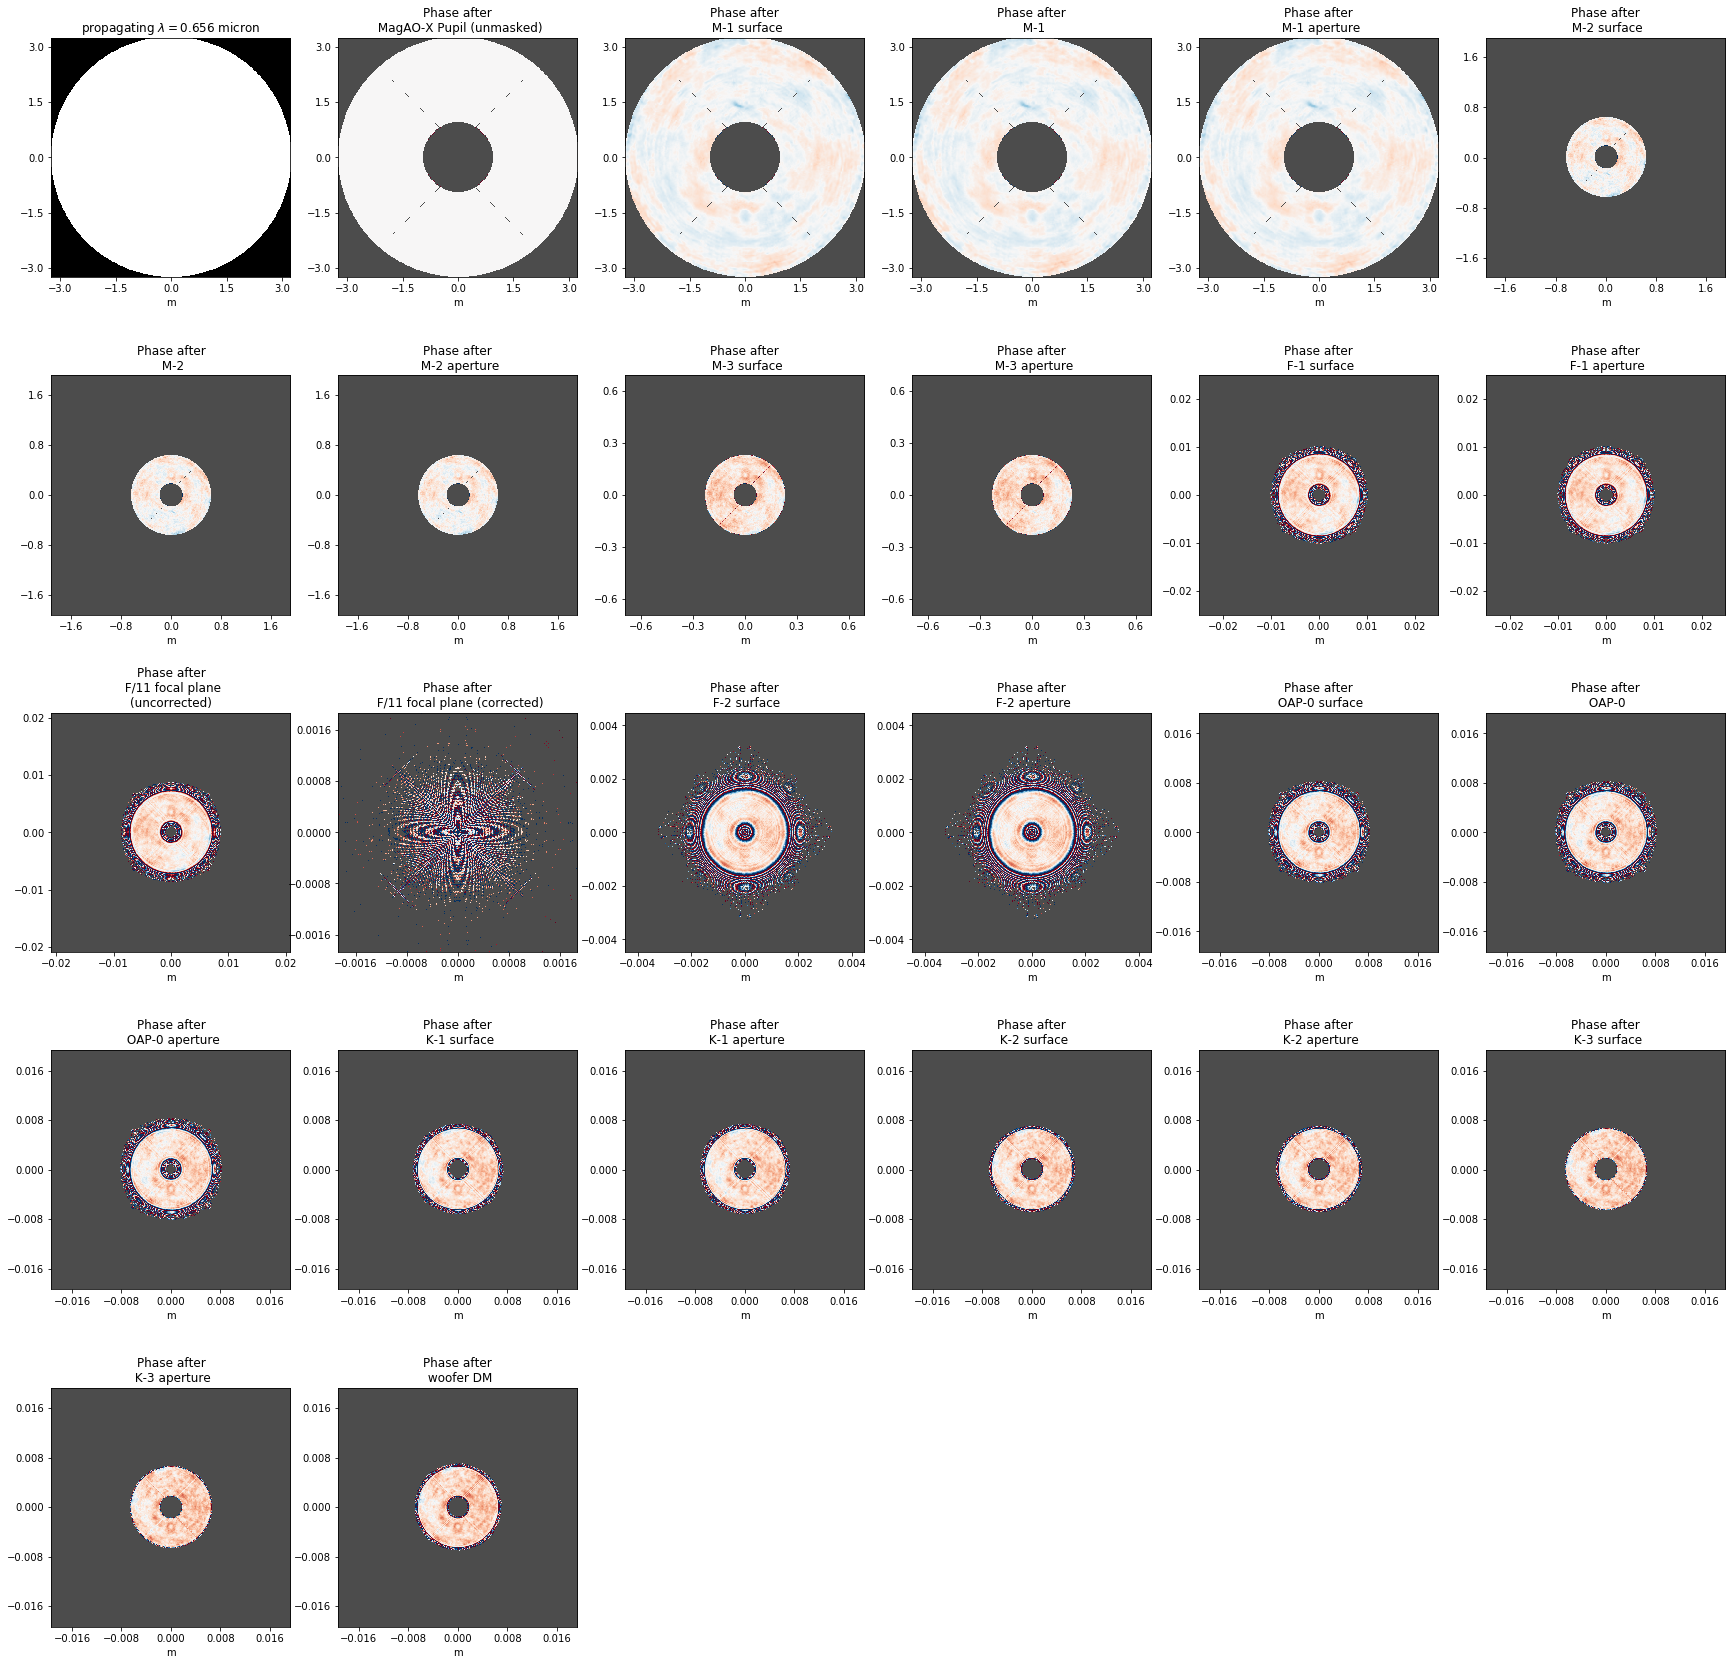

In [9]:
plt.figure(figsize=[30,30])
woof_psf, woof_wfs = magaox.calcPSF(wavelength=testWavelength, display_intermediates=True, return_intermediates=True)

Pull out the phase information for Woofer DM into a workable file

In [10]:
woof_num = len(woof_wfs)-1
woof_intensity = woof_wfs[woof_num].asFITS('intensity')

From the Woofer DM header information, show the Pixel scaling. 

Note that Pixel Scaling is in units of meters/pixel.

In [11]:
woof_pixscl = woof_intensity[0].header['PIXELSCL']
woof_pixscl

2.5161768245152805e-05

Taking a look at the M-2 phase.

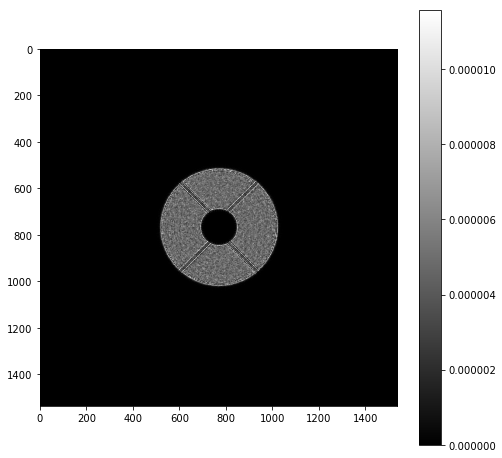

In [12]:
plt.figure(figsize=[8,8])
plt.imshow(woof_intensity[0].data, cmap='gray')
plt.colorbar()

It's a bit too hard to see, so what I do is I save the file as a FITS file and open it up in DS9. 

Alternatively, you could also open up the screencapped image in the same folder. I don't know if the image is coming out okay in Jupyter notebook.

In [13]:
woof_intensity.writeto('output/woof_intensity_newOAPdistance.fits')

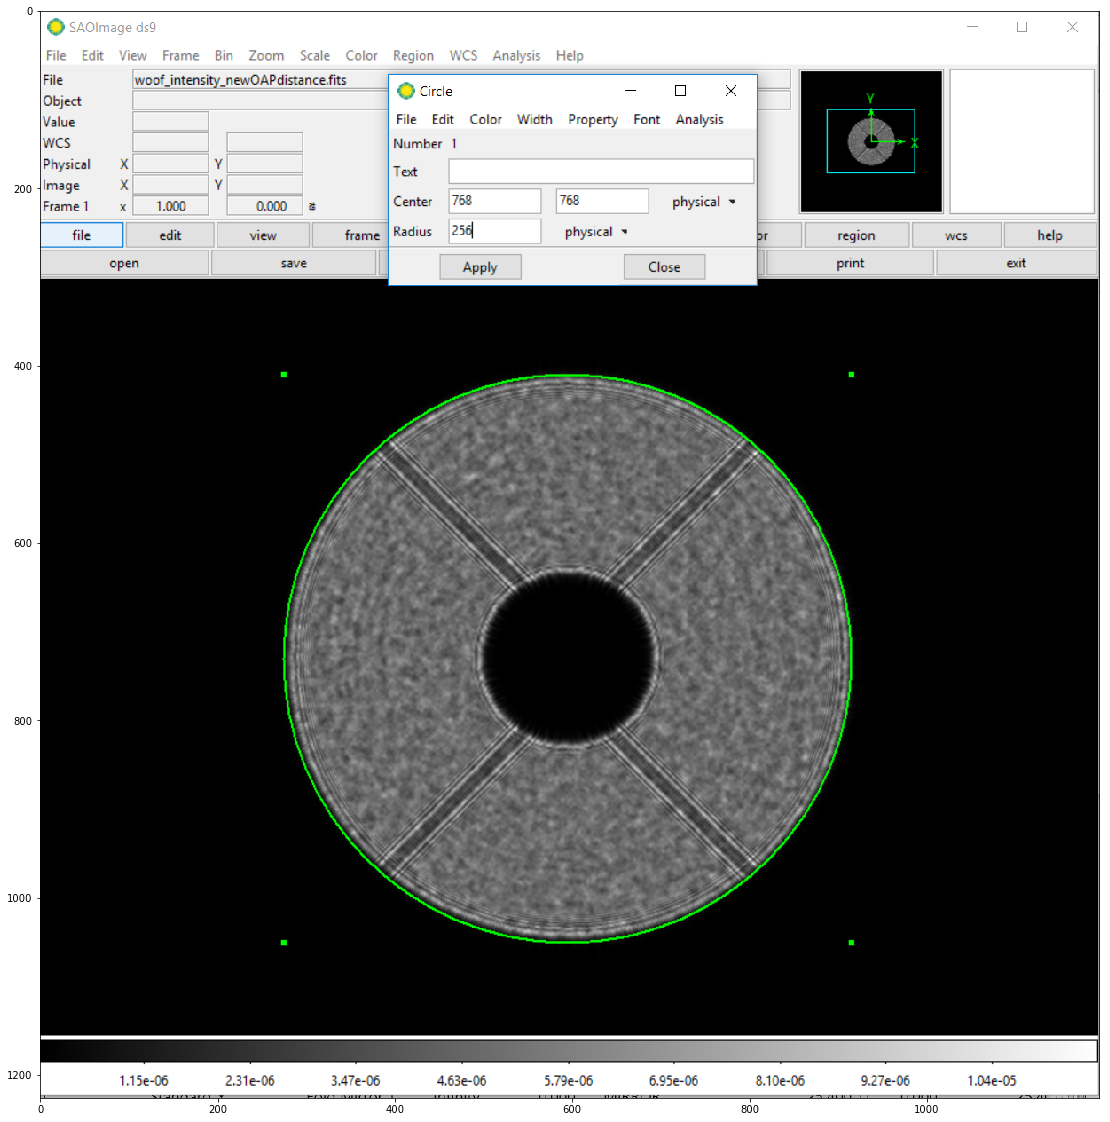

In [14]:
import matplotlib.image as mpimg
#ds9_screenshot = mpimg.imread('output/woofer_ds9_screencap.png')
ds9_screenshot = mpimg.imread('output/woofer_newOAP0distance_ds9_screencap.png')
plt.figure(figsize=[20,20])
plt.imshow(ds9_screenshot)

From ds9, the beam diameter takes up 512 pixels. So, multiply 512 pixels by the pixelscale should feed out the physical beam diameter (in units of meters).

In [15]:
woof_diam = woof_pixscl * 512
woof_diam

0.012882825341518236

Woofer diameter using corrected Periscope Mirror 2 to OAP0 distance: 12.88 mm

Expected beam diameter: 13.05mm

### Our issue:
POPPY produced a beam diameter for the Woofer DM beam diameter at 155.56 mm WHEN we used the Zemax value of 10mm.

Our expected beam diameter for the Woofer DM plane is 13.05 mm.

We think that there's an issue with how POPPY and Zemax understands the distances. In Zemax, the distances between optics are defined from vertex to vertex. So... we may be missing something, somewhere.